1. Please write a program to fetch the historical prices and dates of gold and silver from these 2 URLs:

•      https://www.investing.com/commodities/gold-historical-data

•      https://www.investing.com/commodities/silver-historical-data

and store them locally (in a file or database, as you see fit).

(You can just extract the default data range in each case: no need to interact with the UI elements.)

 

2. Please then write a second program that takes the following 3 command line arguments:

•   Start date (in the format 2017-05-10)

•   End date (in the format 2017-05-22)

•   Commodity type (either "gold" or silver”)

and then returns (via the locally stored data) the mean and variance of the commodity’s price over the specified date range.

For example, the program might be called like so: ./getCommodityPrice 2017-05-01 2017-05-03 gold and would print out a tuple such as: gold 1253.66 35.79

3. As the last step, please write a program to help you decide if the previous gold or silver prices are good predictors for their future prices.

Also do the same to check if an increase or decrease in the price is predictable. (There is no need to do the actual prediction.)

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
from fbprophet import Prophet
from statsmodels.tsa.stattools import adfuller
import datetime
%matplotlib inline

In [2]:
def createDataBaseFromWeb():
    '''
     Create csv dataset of GOLD and SILVER in a specific location
    ''' 
    fileName=['dataForGold.csv','dataForSilver.csv']
    url=["https://www.investing.com/commodities/gold-historical-data","https://www.investing.com/commodities/silver-historical-data"]
    for i in range(len(url)):
        req = Request(url[i], headers={'User-Agent': 'Mozilla/5.0'})
        webpage = urlopen(req).read()
        soup =BeautifulSoup(webpage, "html.parser")
        table = soup.find("table", {"id" : "curr_table"})
        tableRows = [[td.text for td in row.find_all("td")] for row in table.find_all("tr")[1:]]
        tableHeaders = [th.text for th in table.find_all("th")]
        df = pd.DataFrame(tableRows, columns=tableHeaders)
        if not os.path.isfile(fileName[i]):
           df.to_csv(fileName[i],header ='column_names')
        else: # else it exists so append without writing the header
          df.to_csv(fileName[i],mode = 'w',header ='column_names')

In [3]:
def calculateMeanVarianceCommodity(startDay,endDay,commodityName ):
    '''
      Calculate mean and variance of a given commodity in a given 
      time frame specified by startDay and endDay. Here I have used
      simple approach to specify the path of dataset.
    '''
    if str(commodityName).lower()=="gold":
        df1=pd.read_csv("dataForGold.csv")
    elif str(commodityName).lower()=="silver":
         df1=pd.read_csv("dataForSilver.csv")
    startDay=pd.to_datetime(startDay)
    endDay=pd.to_datetime(endDay)
    df1["Date"]=pd.to_datetime(df1.Date)
    priceColumn=df1[(df1.Date>=startDay)&(df1.Date<=endDay)]["Price"]
    if priceColumn.dtype==object:
        priceColumn=priceColumn.str.replace(",","").astype(float)
    return(commodityName,"%.2f" % priceColumn.mean(), "%.2f" % priceColumn.std())

In [4]:
t1=pd.read_csv("C:/Users/12094/DataSciencePractice/dataForGold.csv")

In [5]:
df1=t1['Price']
df1["Price"]=t1["Price"].str.replace(",","").astype(float)

C:\Users\12094\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
# rolmean = pd.rolling(t1["Price"], window=5).mean()
rolmean = df1["Price"].rolling(window=5).mean()
print(rolmean)

0         NaN
1         NaN
2         NaN
3         NaN
4     1296.08
5     1302.55
6     1310.50
7     1318.90
8     1325.62
9     1327.96
10    1333.30
11    1336.56
12    1336.57
13    1334.86
14    1333.72
15    1326.92
16    1320.98
17    1317.87
18    1315.40
19    1314.68
20    1314.74
21    1314.60
Name: Price, dtype: float64


In [7]:
def analysisWithProphet(dataFrame):
    '''
     Analysis and forecasting with Prophet. 
     We will be forecasting for next 5 days
    '''
    df1=dataFrame.copy() # making sure to keep the original data
    df1["Date"]=pd.to_datetime(df1.Date)
    df1.dropna(inplace=True)
    df1.drop(["Open","High","Low","Vol.","Change %"],axis=1,inplace=True)
    # Renaming the columns for Prophet Model
    df1.rename(columns={'Date': 'ds', 'Price':'y'}, inplace=True)
    #Chaning the data type to float
    if df1["y"].dtype==object:
      df1["y"]=df1["y"].str.replace(",","").astype(float)
    # doing log transform 
    df1["y_orig"]=df1["y"]
    df1["y"]=np.log(df1["y"])
    # model training
    model=Prophet()
    model.fit(df1)
    future_data = model.make_future_dataframe(periods=5, freq = 'd')
    forecast_data = model.predict(future_data)
    #print trend and weekly patterrn; 
    model.plot_components(forecast_data)
    forecast_data_orig = forecast_data # making sure to keep the original forecast data
    # converting to the original format
    forecast_data_orig['yhat'] = np.exp(forecast_data_orig['yhat'])
    forecast_data_orig['yhat_lower'] = np.exp(forecast_data_orig['yhat_lower'])
    forecast_data_orig['yhat_upper'] = np.exp(forecast_data_orig['yhat_upper'])
    model.plot(forecast_data_orig)

In [8]:
def testStationarityAndDicky_FullerTest (dataFrame):
    df1=dataFrame.copy() # making sure to keep the original data
    df1["Date"]=pd.to_datetime(df1.Date)
    df1.dropna(inplace=True)
    df1.set_index("Date",inplace=True)
    df1.drop(["Open","High","Low","Vol.","Change %"],axis=1,inplace=True)
    if df1["Price"].dtype==object:
      df1["Price"]=df1["Price"].str.replace(",","").astype(float)
    #Determing rolling statistics
    #rolmean = pd.rolling_mean(df1["Price"], window=5)
    #rolstd = pd.rolling_std(df1["Price"], window=5)
    rolmean=df1["Price"].rolling(window=5).mean()
    rolstd=df1["Price"].rolling(window=5).std()

    #Plot rolling statistics:
    orig = plot.plot(df1["Price"], color='blue',label='Original')
    mean = plot.plot(rolmean, color='red', label='Rolling Mean')
    #std = plot.plot(rolstd, color='black', label = 'Rolling Std')
    plot.legend(loc='best')
    plot.title('Rolling Mean & Standard Deviation')
    plot.show(block=False)
    
    ts=df1["Price"]
    #Performing Dicky-Fuller test:
    print ('Results of Dickey-Fuller Test Before Log Transformation:')
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


# Create data set of GOLD and SILVER  From Web-site www.investing.com

In [9]:
createDataBaseFromWeb()

# Now we will be testing the fuction which calculates mean and variance of the commodity’s price over the specified date range

In [10]:
todays_date=datetime.datetime.today().strftime('%Y-%m-%d')
thirtydays_back=(datetime.datetime.today()-datetime.timedelta(30)).strftime('%Y-%m-%d')

In [11]:
(commodityItemName,commodityItemMean,commodityItemStd)=calculateMeanVarianceCommodity(thirtydays_back, todays_date,"gold")
print(commodityItemName,commodityItemMean,commodityItemStd)
(commodityItemName,commodityItemMean,commodityItemStd)=calculateMeanVarianceCommodity(thirtydays_back, todays_date,"silver")
print(commodityItemName,commodityItemMean,commodityItemStd)

gold 1319.14 15.15
silver 15.74 0.29


# We will test if we see any trend by ploting  the moving average or moving variance and see if it varies with time. This would be done by the function testStationarityAndDicky_FullerTest.  This function will do Dickey-Fuller Test too. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. We will use Prophet in the function analysisWithProphet to predict the values for next 5 days.

# Silver Price Trend and Prediction

 Silver Trend and Prediction


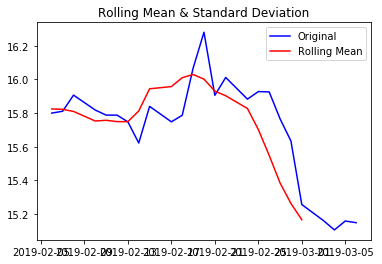

Results of Dickey-Fuller Test Before Log Transformation:
Test Statistic                 -1.991223
p-value                         0.290435
#Lags Used                      0.000000
Number of Observations Used    24.000000
Critical Value (1%)            -3.737709
Critical Value (5%)            -2.992216
Critical Value (10%)           -2.635747
dtype: float64


In [12]:
print(" Silver Trend and Prediction")
df=pd.read_csv("C:/Users/12094/DataSciencePractice/dataForSilver.csv")
testStationarityAndDicky_FullerTest(df)

# We can  see moving average is varying from the graph and also verifed by Dickey-Fuller Test with 10% confidence level. From the Graph, it is noticible that it has slight downward trend and We could have used Differencing to eliminate Trend and seasonality to investigate furher. Instead Prophet is used to show trend and the forcast

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 19.0.
C:\Users\12094\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


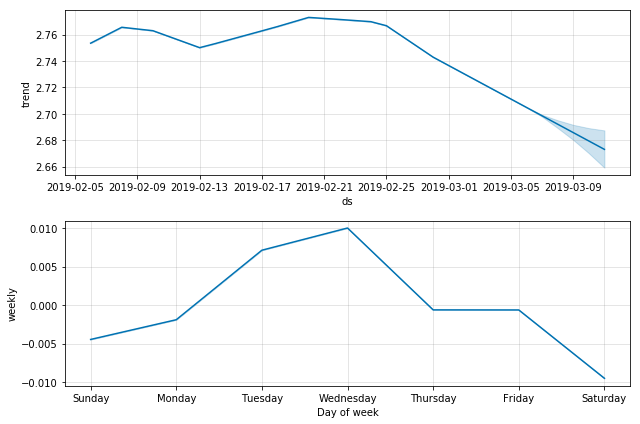

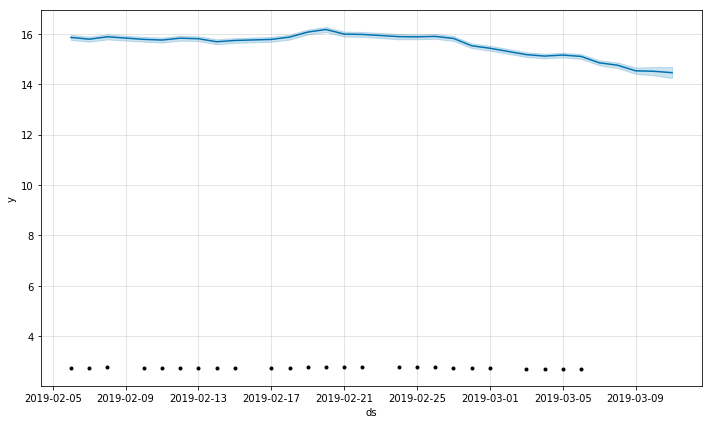

In [13]:
analysisWithProphet(df)

# Dickey-Fuller Test confirm the observation regarding silver price and predicted value.  Variable y in the last graph shows the silver price

# Gold Price Trend and Prediction

 Gold Trend and Prediction


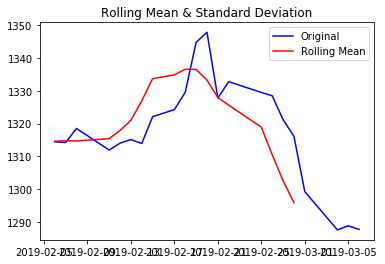

Results of Dickey-Fuller Test Before Log Transformation:
Test Statistic                -60.869360
p-value                         0.000000
#Lags Used                      9.000000
Number of Observations Used    12.000000
Critical Value (1%)            -4.137829
Critical Value (5%)            -3.154972
Critical Value (10%)           -2.714477
dtype: float64


In [14]:
print(" Gold Trend and Prediction")
df=pd.read_csv("C:/Users/12094/DataSciencePractice/dataForGold.csv")
testStationarityAndDicky_FullerTest(df)

# We can  see moving average is varying from the graph and also verifed by Dickey-Fuller Test with 10% confidence level. From the Graph, it is not clear what is the trend and We could have used Differencing to eliminate Trend and seasonality to investigate furher. Instead Prophet is used to show trend and the forcast.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 16.0.


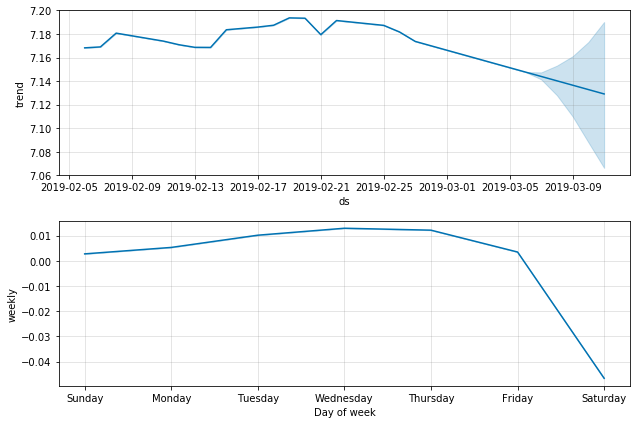

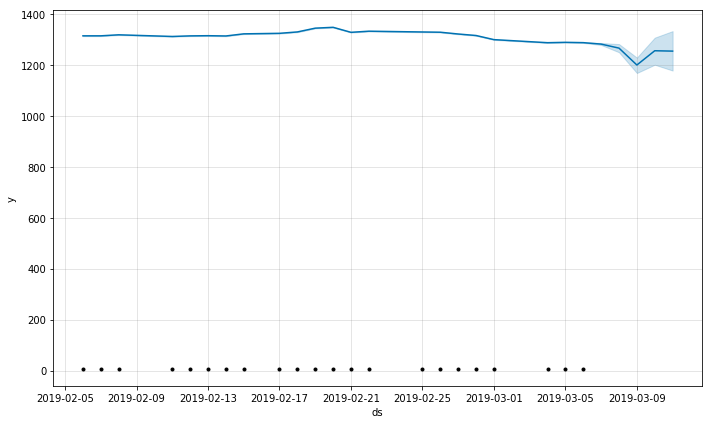

In [15]:
analysisWithProphet(df)

# Dickey-Fuller Test confirms that Gold price  trend  is more or less static. It also shows weekly pattern. The predicted values are shown in the last graph . Here variable y in the last graph shows the GOLD price